In [1]:
import anitraintools as alt
import os
import itertools
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#nwdir = '/path/to/networks/'
#h5dir = '/path/to/ANI-Tools/NeuroChem_training/h5files'
nwdir = '/data/cdever01/ANI-Tools/NeuroChem_training/sample_nets/'
h5dir = '/data/cdever01/ANI-Tools/NeuroChem_training/h5files/'

In [3]:
Nnets = 2 # networks in ensemble
Nblock = 16 # Number of blocks in split
Nbvald = 2 # number of valid blocks
Nbtest = 1 # number of test blocks

In [4]:
#Atom Types
Atyp=['H','C','O', 'N']

In [5]:
#Define parameter designer
par = alt.anitrainerparamdesigner()


#Set AEV parameters
par.set_params("NsR",16)       #Shifting radial parmaeters
par.set_params("NsaR",4)       #Shifting angular radial parameters
par.set_params("NsZ",8)        #Shifting angular parameters
par.set_params("Zeta",3.2)     #affects width of angular gaussians
par.set_params("EtaA",8.0)     #affects width of angular gaussians
par.set_params("EtaR",16)      #affects width of radial gaussians
par.set_params("Rcr",5.2)       #Radial cutoff radius
par.set_params("Rca",3.5)      #Angular cutoff radius
par.set_params("TM",1)
par.set_params("Atyp",Atyp)    #Atom types


#write the parameter file
par.write_parameter_file(par_path=nwdir)

In [6]:
# Define input designer
aipt = alt.anitrainerinputdesigner()


# Setup network architechtures for each atomic symbol and add layers to the network
#The following activation functions are supported:
#2:RELU
#5:Gaussian
#6:Linear
#9:CELU

layer_dictsH = [{"nodes":48,"activation":9,"l2norm":0,"l2valu":  0.00001},
                {"nodes":32,"activation":9,"l2norm":0,"l2valu": 0.000001},
                {"nodes":1,"activation":9,"l2norm":0,"l2valu":0.000001}]

layer_dictsC = [{"nodes":48,"activation":9,"l2norm":0,"l2valu":  0.00001},
                {"nodes":32,"activation":9,"l2norm":0,"l2valu": 0.000001},
                {"nodes":1,"activation":9,"l2norm":0,"l2valu":0.000001}]

layer_dictsN = [{"nodes":48,"activation":9,"l2norm":0,"l2valu":  0.00001},
                {"nodes":32,"activation":9,"l2norm":0,"l2valu": 0.000001},
                {"nodes":1,"activation":9,"l2norm":0,"l2valu":0.000001}]

layer_dictsO = [{"nodes":48,"activation":9,"l2norm":0,"l2valu":  0.00001},
                {"nodes":32,"activation":9,"l2norm":0,"l2valu": 0.000001},
                {"nodes":1,"activation":9,"l2norm":0,"l2valu":0.000001}]


for l in layer_dictsH:
    aipt.add_layer("H",l)

for l in layer_dictsC:
    aipt.add_layer("C",l)

for l in layer_dictsN:
    aipt.add_layer("N",l)

for l in layer_dictsO:
    aipt.add_layer("O",l)

# Output the layer parameters
#aipt.print_layer_parameters()

# Customize training parameters
aipt.set_parameter("sflparamsfile",par.params["file_name"])
aipt.set_parameter("atomEnergyFile",'sae.dat')
aipt.set_parameter("tolr",40)
aipt.set_parameter("tbtchsz",15)
aipt.set_parameter("vbtchsz",15)
aipt.set_parameter("nkde",0)
aipt.set_parameter("energy",1)
aipt.set_parameter("force",1)
aipt.set_parameter("fmult",10.0)
aipt.set_parameter("feps",0.001)
aipt.set_parameter("eunits",'default')
aipt.set_parameter("factor",1.0)
aipt.set_parameter("pbc",0)
aipt.set_parameter("boxx",6.0000)
aipt.set_parameter("boxy",6.0000)
aipt.set_parameter("boxz",6.0000)


# Print all training parameters
#aipt.print_training_parameters()

# Write the input  and parameter files
iptsize=par.inp_size()
aipt.write_input_file(nwdir+'inputtrain.ipt',iptsize)

In [7]:
netdict = {'iptfile' :nwdir+'inputtrain.ipt',
           'cnstfile':nwdir+par.params["file_name"],
           'saefile' :nwdir+'sae.dat',
           'atomtyp':Atyp}

GPU = [0]

## Train the ensemble ##
aet = alt.alaniensembletrainer(nwdir, netdict, h5dir, Nnets)
#aet.build_strided_training_cache(Nblock,Nbvald,Nbtest,build_test=False, forces=False, grad=False,rmhighe=False)
#aet.train_ensemble(GPU)

In [8]:
stats = aet.get_train_stats()
ep=[]
ma=[]
rm=[]
for i in range(len(stats[0]['ERROR']['E (default)'])):
        ep.append(i)
        ma.append(stats[0]['ERROR']['E (Ha)'][i][0])
        rm.append(stats[0]['ERROR']['E (default)'][i][0])
rm=np.array(rm)*627.509608
ma=np.array(ma)*627.509608

reading: /data/cdever01/ANI-Tools/NeuroChem_training/sample_nets/train0/output.opt
reading: /data/cdever01/ANI-Tools/NeuroChem_training/sample_nets/train1/output.opt


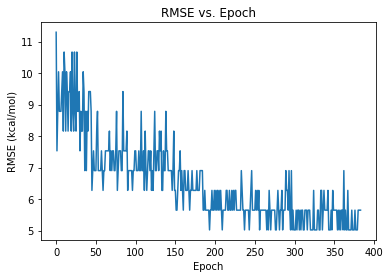

In [9]:
plt.plot(ep, rm)
plt.xlabel('Epoch')
plt.ylabel('RMSE (kcal/mol)')
plt.title('RMSE vs. Epoch')
plt.savefig('images/RMSE.png')

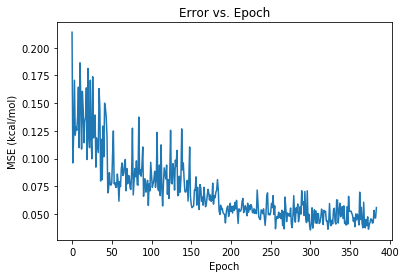

In [10]:
plt.plot(ep, ma)
plt.xlabel('Epoch')
plt.ylabel('MSE (kcal/mol)')
plt.title('Error vs. Epoch')
plt.savefig('images/MSE.png')